<a href="https://colab.research.google.com/github/nithinrk11/Feynn-Labs-Machine-Learning-Internship/blob/main/Project%202B/EV_Sales_Market_Segmentation_Indian_EV_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # EV Sales Market Segmentation Indian EV market.
The Datasets used here are:
* 'ev_sales_by_makers_and_cat_15-24.csv'[link](https://www.kaggle.com/datasets/srinrealyf/india-ev-market-data?select=ev_sales_by_makers_and_cat_15-24.csv) from kaggle (VAHAN Dasboard based dataset) for EV sales by companies with EV types.
*For EV models, price and other detail, the 'Vehicles Dataset'[link](hhttps://github.com/nithinrk11/Feynn-Labs-Machine-Learning-Internship/blob/main/Project%202B/Datasets/vehicle_dataset.csv), this is a webscraped dataset  various open source automotive websites.

---

In [194]:
!pip install yellowbrick
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer
import warnings

###Load the datasets

In [195]:
!git clone https://github.com/nithinrk11/Feynn-Labs-Machine-Learning-Internship.git
%cd Feynn-Labs-Machine-Learning-Internship

Cloning into 'Feynn-Labs-Machine-Learning-Internship'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 100 (delta 26), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 2.44 MiB | 10.55 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/Feynn-Labs-Machine-Learning-Internship/Feynn-Labs-Machine-Learning-Internship/Feynn-Labs-Machine-Learning-Internship/Feynn-Labs-Machine-Learning-Internship/Feynn-Labs-Machine-Learning-Internship/Feynn-Labs-Machine-Learning-Internship/Feynn-Labs-Machine-Learning-Internship


In [196]:
# Load datasets
df_a = pd.read_csv('/content/Feynn-Labs-Machine-Learning-Internship/Project 2B/Datasets/ev_sales_by_makers_and_cat_15-24.csv')
df_b = pd.read_csv('/content/Feynn-Labs-Machine-Learning-Internship/Project 2B/Datasets/vehicle_dataset.csv')


##Feature Extraction

>Here we compare the first word of each data inside 'Maker' and 'Brand' columns of sales dataset and vehicle dataset, when matched their respective column datas of total sald unit values 'Total_Sales' is extracted and passed to the sales dataset, thereby having a more featured dataset is extracted

In [197]:

# Extract the first word from the "Maker" column in df_a and convert to lowercase
df_a['First_Word_A'] = df_a['Maker'].apply(lambda x: str(x).split()[0].lower())

# Extract the first word from the "Brand" column in df_b and convert to lowercase
df_b['First_Word_B'] = df_b['Brand'].apply(lambda x: str(x).split()[0].lower())

# Combine the first word and the "Cat" column in df_a to create a new key
df_a['Combined_Key_A'] = df_a['First_Word_A'] + "_" + df_a['Cat'].astype(str).str.lower()

# Combine the first word and the "Class" column in df_b to create a new key
df_b['Combined_Key_B'] = df_b['First_Word_B'] + "_" + df_b['Class'].astype(str).str.lower()

# Handle duplicate values in 'Combined_Key_A' by taking the first occurrence
df_a = df_a.drop_duplicates(subset=['Combined_Key_A'], keep='first')

# Set the index of df_a to 'Combined_Key_A' for easy mapping
df_a.set_index('Combined_Key_A', inplace=True)

# Map the entire "Maker" value and "Total Sales" to df_b based on the combined key matching
df_b['Matched_Maker'] = df_b['Combined_Key_B'].map(df_a['Maker'])
df_b['Total_Sold_units_by_Maker'] = df_b['Combined_Key_B'].map(df_a['Total_Sales'])

# Drop the temporary columns
df_b.drop(columns=['First_Word_B', 'Combined_Key_B'], inplace=True)


###Data Preprocessing

In [198]:
#drop columns 0, 1 and 9

df_b = df_b.drop(df_b.columns[[0, 1, 10]], axis=1)
df_b.head()


,Rating(out of 5),Top Speed (kmph),Range (km),Weight (kg),Charging Time (hrs),Price,Class,Load Capacity,Total_Sold_units_by_Maker
0,4.7,116,151,-,-,104999,2W,-,"588,266.00"
1,5,194,579,-,-,199999,2W,-,"588,266.00"
2,5,105,117,-,-,84999,2W,-,"588,266.00"
3,4.3,85,95,101,5,84999,2W,-,"588,266.00"
4,3.7,63,123,-,6,110208,2W,-,"177,128.00"


In [199]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rating(out of 5)           236 non-null    object 
 1   Top Speed (kmph)           236 non-null    object 
 2   Range (km)                 236 non-null    object 
 3   Weight (kg)                236 non-null    object 
 4   Charging Time (hrs)        236 non-null    object 
 5   Price                      236 non-null    int64  
 6   Class                      236 non-null    object 
 7   Load Capacity              236 non-null    object 
 8   Total_Sold_units_by_Maker  176 non-null    float64
dtypes: float64(1), int64(1), object(7)
memory usage: 16.7+ KB


In [200]:
#remove W from every data inside Class for effective calculation

df_b['Class'] = df_b['Class'].str.replace('W', '')


In [201]:
#Selecting relevant columns and manage dataypes
cols_to_convert = df_b.columns[:11]

# Replace '-' with NaN and then fill with 0
df_b[cols_to_convert] = df_b[cols_to_convert].replace('-', np.nan).fillna(0)


# Fill NaN values with 0
df_b.fillna(0, inplace=True)


In [202]:
# convert data type of column 1 to 7 into int and column 0 to float

# Convert columns 1 to 7 to integers
for col in df_b.columns[1:8]:
  df_b[col] = df_b[col].astype(int)


df_b[df_b.columns[0]] = df_b[df_b.columns[0]].astype(float)

In [203]:
df_b.columns

Index(['Rating(out of 5)', 'Top Speed (kmph)', 'Range (km)', 'Weight (kg)',
       'Charging Time (hrs)', 'Price', 'Class', 'Load Capacity',
       'Total_Sold_units_by_Maker'],
      dtype='object')

---
## Segment Extraction
> ### K-Means elbow visualiser for optimal segments

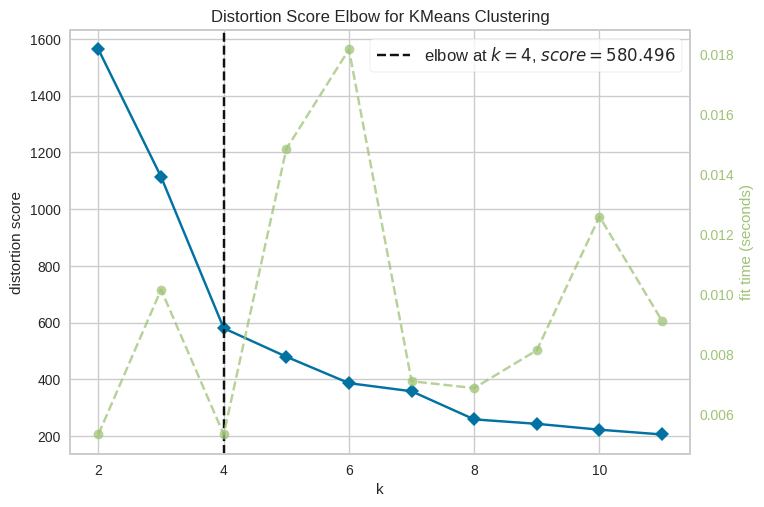

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [204]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_b[['Rating(out of 5)', 'Top Speed (kmph)', 'Range (km)', 'Weight (kg)','Charging Time (hrs)', 'Price', 'Class', 'Load Capacity', 'Total_Sold_units_by_Maker']])

# Create a KMeans model
model = KMeans(random_state=42, n_init='auto')

# Use the KElbowVisualizer to find the optimal number of clusters
visualizer = KElbowVisualizer(model, k=(2,12))

# Fit the data to the visualizer
visualizer.fit(X_scaled)

# Render the plot
visualizer.show()


>Optimal number of segment found is 4

##Principle Component Analysis

In [205]:
# Perform PCA and K-Means

X = df_b[['Rating(out of 5)', 'Top Speed (kmph)', 'Range (km)', 'Weight (kg)','Charging Time (hrs)', 'Price', 'Class', 'Load Capacity', 'Total_Sold_units_by_Maker']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)

# Apply K-Means clustering
from sklearn.cluster import KMeans # Import KMeans
kmeans = KMeans(n_clusters=4, random_state=42) # You can adjust the number of clusters as needed
clusters = kmeans.fit_predict(X_pca) # Generate cluster assignments

# Create a DataFrame for PCA results
pca_df_b = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9'])
pca_df_b['Cluster'] = clusters

# Output the loadings for reference
# Get PCA components (loadings)
components = pca.components_.T
loadings_df_b = pd.DataFrame(components, index=X.columns, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9'])
print("PCA Loadings:")
loadings_df_b

PCA Loadings:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Rating(out of 5),0.35,0.39,-0.01,0.06,-0.22,-0.50,-0.10,0.63,-0.12
Top Speed (kmph),0.46,-0.02,0.19,0.25,0.26,-0.03,0.66,-0.17,-0.40
Range (km),0.06,0.60,0.06,0.14,-0.02,-0.26,0.08,-0.53,0.51
Weight (kg),0.41,-0.05,-0.29,0.45,0.49,0.14,-0.52,-0.02,0.06
Charging Time (hrs),0.43,-0.07,-0.19,-0.07,-0.67,0.13,-0.22,-0.41,-0.28
Price,-0.11,0.54,-0.02,0.23,-0.15,0.73,0.11,0.24,-0.09
Class,-0.41,0.33,0.05,0.03,0.19,-0.22,-0.30,-0.27,-0.69
Load Capacity,-0.30,-0.28,0.19,0.80,-0.36,-0.16,-0.00,0.02,0.03
Total_Sold_units_by_Maker,0.21,-0.01,0.89,-0.10,0.02,0.16,-0.35,0.00,0.04


>PC1 and PC2 captures the most loadings

##Segment Speration plot using PCA and K-Means (Profiling Segments)

<ipython-input-206-7fa47676cd5b>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0, 0, loadings_df_b['PC1'][i]*4, loadings_df_b['PC2'][i]*4, color='r', alpha=0.5, head_width=0.03, head_length=0.05)
<ipython-input-206-7fa47676cd5b>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings_df_b['PC1'][i]*4.1, loadings_df_b['PC2'][i]*4.1, feature, color='black', ha='center', va='center', fontsize=12)


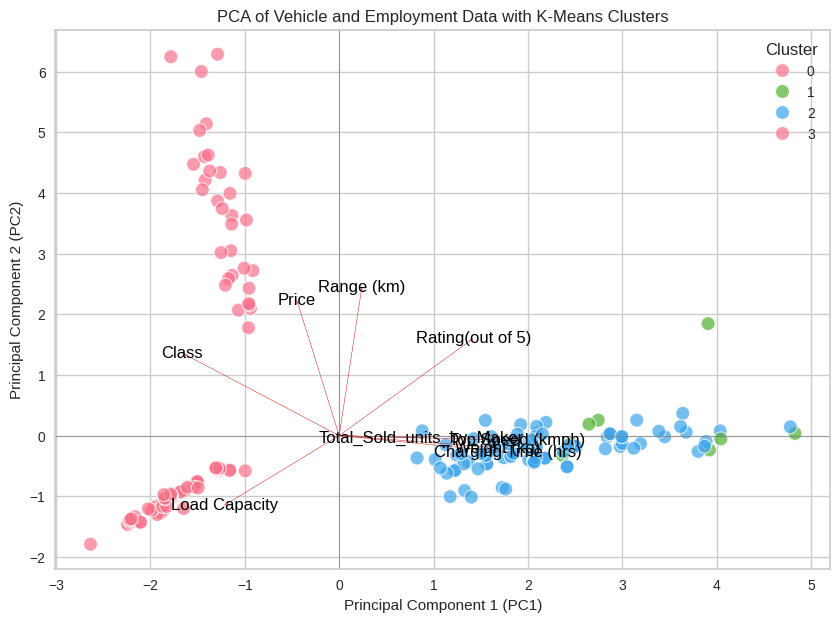

In [206]:
# Set up the figure and axes
plt.figure(figsize=(10, 7))

# Scatter plot of PC1 vs PC2, colored by the K-Means cluster assignments
sns.scatterplot(x=pca_df_b['PC1'], y=pca_df_b['PC2'], hue=pca_df_b['Cluster'], palette='husl', s=100, alpha=0.7)

# Add the PCA loadings as arrows
for i, feature in enumerate(loadings_df_b.index):
    plt.arrow(0, 0, loadings_df_b['PC1'][i]*4, loadings_df_b['PC2'][i]*4, color='r', alpha=0.5, head_width=0.03, head_length=0.05)
    plt.text(loadings_df_b['PC1'][i]*4.1, loadings_df_b['PC2'][i]*4.1, feature, color='black', ha='center', va='center', fontsize=12)

# Set labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA of Vehicle and Employment Data with K-Means Clusters')
plt.grid(True)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)

# Show the plot
plt.show()


> Feature Directions:

* The arrows pointing from the origin to the labels of the features (Price Range, Rating, Total_Sales, Top Speed, Charging Time, Load Capacity) indicate the direction in which these features contribute to the variation captured by PC1 and PC2.
* Range (km) and Price: The arrows for Range (km) and Price are pointing in a similar direction, suggesting that vehicles with higher ranges tend to have higher prices.
* Class : The importance of Class variable suggests us to perform seperate segmentation analyis for different EV types (2W, 3W, and 4W)

> let us now perform segmentation for each vehicle types

#2 Wheeler Vehicle type Segmentation

In [207]:
#make a copy datasets where class = 2 from df_b

df2 = df_b[df_b['Class'] == 2].copy()
df2.head()


,Rating(out of 5),Top Speed (kmph),Range (km),Weight (kg),Charging Time (hrs),Price,Class,Load Capacity,Total_Sold_units_by_Maker
0,4.70,116,151,0,0,104999,2,0,"588,266.00"
1,5.00,194,579,0,0,199999,2,0,"588,266.00"
2,5.00,105,117,0,0,84999,2,0,"588,266.00"
3,4.30,85,95,101,5,84999,2,0,"588,266.00"
4,3.70,63,123,0,6,110208,2,0,"177,128.00"


In [208]:
#drop load capacity and class

df2 = df2.drop(['Load Capacity', 'Class'], axis=1)


###K-Means elbow visualiser for optimal segments

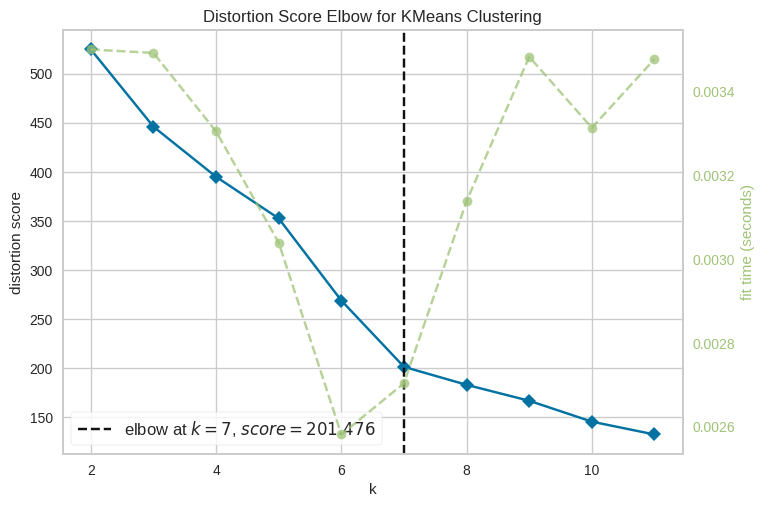

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [209]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df2[['Rating(out of 5)', 'Top Speed (kmph)', 'Range (km)', 'Weight (kg)', 'Charging Time (hrs)', 'Price', 'Total_Sold_units_by_Maker']])

# Create a KMeans model
model = KMeans(random_state=42, n_init='auto')

# Use the KElbowVisualizer to find the optimal number of clusters
visualizer = KElbowVisualizer(model, k=(2,12))

# Fit the data to the visualizer
visualizer.fit(X_scaled)

# Render the plot
visualizer.show()


>Optimal number of clusters found is 7

##Segment Speration plot using PCA and K-Means (Profiling Segments)

In [210]:
# Select features for PCA and clustering
X = df2[['Rating(out of 5)', 'Top Speed (kmph)', 'Range (km)', 'Weight (kg)', 'Charging Time (hrs)', 'Price', 'Total_Sold_units_by_Maker']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # You can use more components if needed
X_pca = pca.fit_transform(X_scaled)

# Determine the optimal number of clusters
kmeans = KMeans(n_clusters=7, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add PCA results and cluster labels to DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters


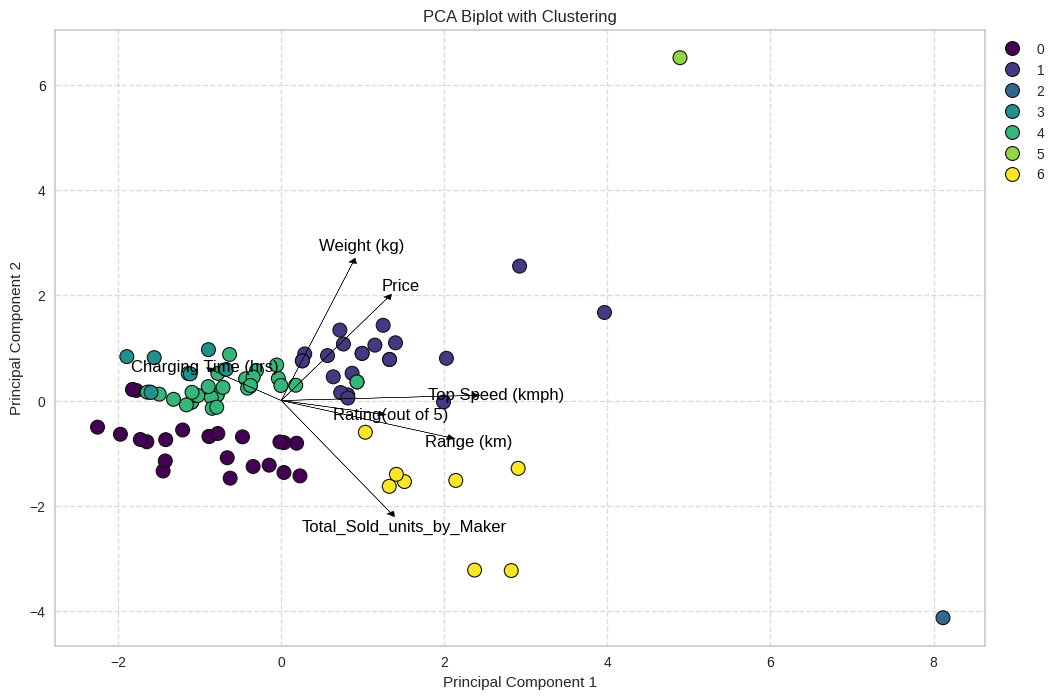

In [211]:
# Plot PCA Biplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', edgecolor='k', s=100)

# Add arrows for feature loadings
features = X.columns
for i, feature in enumerate(features):
    plt.arrow(0, 0, pca.components_[0, i]*4, pca.components_[1, i]*4,
              head_width=0.1, head_length=0.1, fc='black', ec='black')
    plt.text(pca.components_[0, i] *4.5, pca.components_[1, i] *4.5, feature,
             color='black', ha='center', va='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot with Clustering')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


>Observations:

* Price and Weight (kg): These arrows point to the upper right, suggesting that these features are strongly correlated with each other and contribute positively to both PC1 and PC2. This means that vehicles with higher prices also tend to have greater weight.
* Top Speed (kmph): The arrow points to the right, suggesting it primarily contributes to PC1.
* Range (km): The arrow points to the lower right, indicating a strong positive correlation with PC1 but a slightly negative contribution to PC2.
* Rating (out of 5): This arrow is relatively shorter, suggesting it has a smaller impact on the principal components compared to other features.
* Total Sold Units by Maker: This arrow points to the lower right, indicating that higher sales units are associated with higher PC1 values.
* Charging Time (hrs): The arrow points to the left, suggesting that it negatively correlates with PC1 and slightly with PC2, meaning that vehicles with longer charging times are associated with lower PC1 values.
* "Charging Time (hrs)" is negatively correlated, meaning that higher-priced and ranged vehicles might have shorter charging times.


##Selecting the Target Segments

In [212]:
# Add cluster labels to the original DataFrame
df2['Segment'] = clusters
import pandas as pd

# Set pandas display options
pd.set_option('display.float_format', '{:,.2f}'.format)

# Group by cluster and calculate the mean of numeric features
cluster_profiles = df2.groupby('Segment').mean()
print("Cluster Profiles:")
cluster_profiles


Cluster Profiles:


,Rating(out of 5),Top Speed (kmph),Range (km),Weight (kg),Charging Time (hrs),Price,Total_Sold_units_by_Maker
Segment,,,,,,,
0,3.58,43.71,99.12,7.38,5.92,"90,288.83","72,020.50"
1,4.32,93.86,145.18,132.95,5.32,"163,443.91","51,281.91"
2,5.00,194.00,579.00,0.00,0.00,"199,999.00","588,266.00"
3,0.28,46.00,95.50,103.50,3.83,"94,548.67","6,850.17"
4,3.75,41.31,86.46,85.57,4.11,"83,850.20","13,404.11"
5,4.50,120.00,130.00,231.00,4.00,"1,490,000.00",0.00
6,4.20,98.62,132.50,55.00,2.62,"125,680.00","464,948.62"



> Based on the segment profiles, `Segment 0` seems promising interms of all the variables. with best pricing but has a moderate rating. and interms of ratings, `Segment 2` seems also promising, but comes under expensive vehicle group.
 ---

#3 Wheeler Vehicle type Segmentation

In [213]:
#make a copy datasets where class = 3 from df_b

df3 = df_b[df_b['Class'] == 3].copy()
df3.head()


,Rating(out of 5),Top Speed (kmph),Range (km),Weight (kg),Charging Time (hrs),Price,Class,Load Capacity,Total_Sold_units_by_Maker
97,0.00,0,0,0,0,59000,3,0,"3,726.00"
98,0.00,0,0,0,0,60000,3,0,"3,726.00"
99,0.00,0,0,0,0,60000,3,0,"3,726.00"
100,0.00,0,0,0,0,60000,3,500,"3,726.00"
101,0.00,0,0,0,0,65000,3,1000,"3,726.00"


In [214]:
#drop columns 0,1,2,3,4,6

df3 = df3.drop(df3.columns[[0,1,2,3,4,6]], axis=1)
df3.head()


,Price,Load Capacity,Total_Sold_units_by_Maker
97,59000,0,"3,726.00"
98,60000,0,"3,726.00"
99,60000,0,"3,726.00"
100,60000,500,"3,726.00"
101,65000,1000,"3,726.00"


###K-Means elbow visualiser for optimal segments

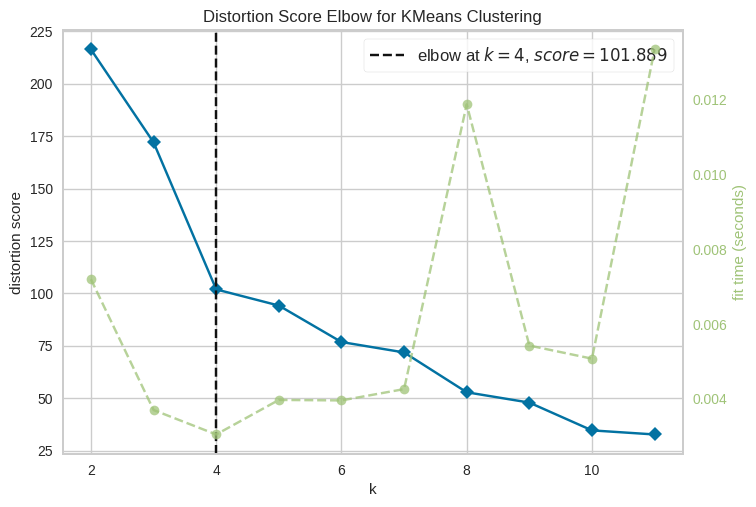

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [215]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df3[['Price', 'Load Capacity', 'Total_Sold_units_by_Maker']])

# Create a KMeans model
model = KMeans(random_state=42, n_init='auto')

# Use the KElbowVisualizer to find the optimal number of clusters
visualizer = KElbowVisualizer(model, k=(2,12))

# Fit the data to the visualizer
visualizer.fit(X_scaled)

# Render the plot
visualizer.show()


In [216]:
# Select features for PCA and clustering
X = df3[['Price', 'Load Capacity', 'Total_Sold_units_by_Maker']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # You can use more components if needed
X_pca = pca.fit_transform(X_scaled)

# Determine the optimal number of clusters
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add PCA results and cluster labels to DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters


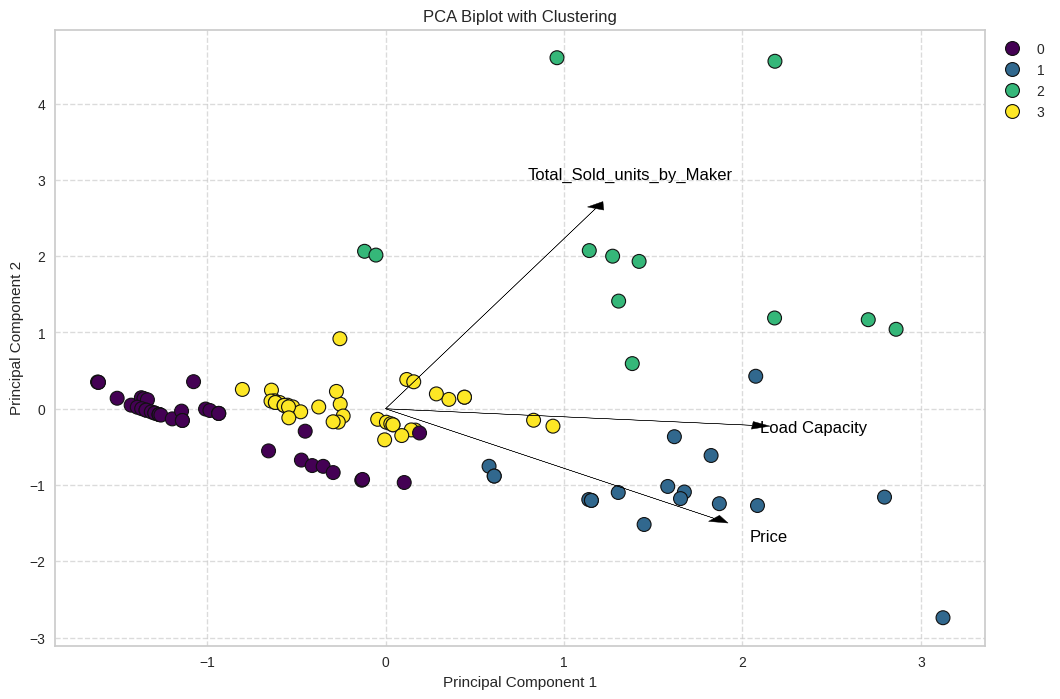

In [217]:
# Plot PCA Biplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', edgecolor='k', s=100)

# Add arrows for feature loadings
features = X.columns
for i, feature in enumerate(features):
    plt.arrow(0, 0, pca.components_[0, i]*3, pca.components_[1, i]*3,
              head_width=0.1, head_length=0.1, fc='black', ec='black')
    plt.text(pca.components_[0, i] * 3.5, pca.components_[1, i] * 3.5, feature,
             color='black', ha='center', va='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot with Clustering')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


> Observations:

* Total Sold Units by Maker: This arrow points upwards and slightly to the right, indicating that it has a positive correlation with both PC1 and PC2. Vehicles in the upper-right region likely have higher total sold units by their maker.
* Load Capacity: This arrow points to the right, showing a strong positive correlation with PC1. This suggests that vehicles with higher load capacity are associated with higher PC1 values.
* Price: The arrow points downward and slightly to the right, indicating that higher prices are negatively correlated with PC2 but positively correlated with PC1.

#Selecting the Target Segments

In [218]:
# Add cluster labels to the original DataFrame
df3['Segment'] = clusters
import pandas as pd

# Set pandas display options
pd.set_option('display.float_format', '{:,.2f}'.format)

# Group by cluster and calculate the mean of numeric features
cluster_profiles = df3.groupby('Segment').mean()
print("Cluster Profiles:")
cluster_profiles


Cluster Profiles:


,Price,Load Capacity,Total_Sold_units_by_Maker
Segment,,,
0,"174,256.41",35.15,"1,771.82"
1,"393,444.44",789.22,"4,891.17"
2,"231,166.67",565.08,"83,441.50"
3,"126,368.42",569.03,"4,912.82"


>Based on the profile, `Segment 2` appears to be the best target segment due to the following reasons:

* High Market Demand: It has the highest total sold units, indicating strong customer acceptance.
* Balanced Pricing: The price is moderate, making it accessible to a broad customer base.
* High Load Capacity: It offers a good load capacity, making it suitable for commercial or heavy-duty use.

#4 Wheeler Vehicle type Segmentation

In [219]:
#make a copy datasets where class = 4 from df_b

df4 = df_b[df_b['Class'] == 4].copy()
df4.head()


,Rating(out of 5),Top Speed (kmph),Range (km),Weight (kg),Charging Time (hrs),Price,Class,Load Capacity,Total_Sold_units_by_Maker
204,5.00,0,230,0,0,798000,4,0,"23,342.00"
205,5.00,0,315,0,0,869000,4,0,"19,798.00"
206,4.50,0,320,0,0,1150000,4,0,0.00
207,5.00,0,315,0,0,1249000,4,0,"19,798.00"
208,5.00,0,312,0,0,1449000,4,0,"19,798.00"


In [220]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 204 to 235
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rating(out of 5)           32 non-null     float64
 1   Top Speed (kmph)           32 non-null     int64  
 2   Range (km)                 32 non-null     int64  
 3   Weight (kg)                32 non-null     int64  
 4   Charging Time (hrs)        32 non-null     int64  
 5   Price                      32 non-null     int64  
 6   Class                      32 non-null     int64  
 7   Load Capacity              32 non-null     int64  
 8   Total_Sold_units_by_Maker  32 non-null     float64
dtypes: float64(2), int64(7)
memory usage: 2.5 KB


In [221]:
#drop columns 1,3,4,6,7

df4 = df4.drop(df4.columns[[1, 3, 4, 6, 7]], axis=1)
df4.head()


,Rating(out of 5),Range (km),Price,Total_Sold_units_by_Maker
204,5.00,230,798000,"23,342.00"
205,5.00,315,869000,"19,798.00"
206,4.50,320,1150000,0.00
207,5.00,315,1249000,"19,798.00"
208,5.00,312,1449000,"19,798.00"


###K-Means elbow visualiser for optimal segments

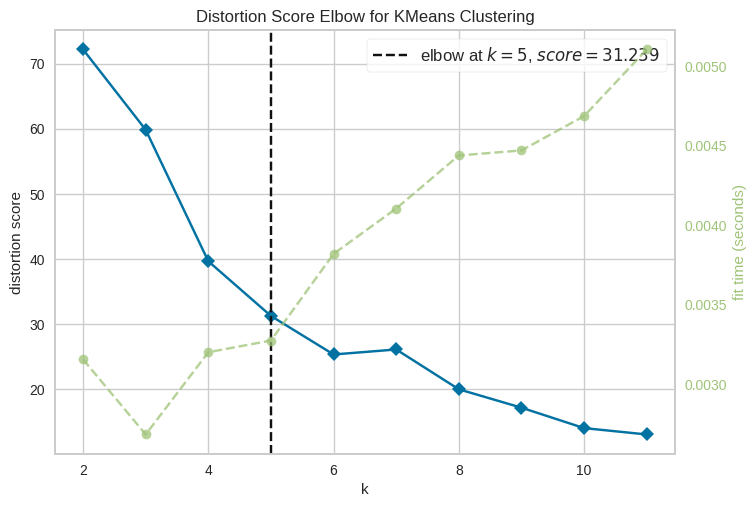

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [222]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df4[['Rating(out of 5)', 'Range (km)', 'Price', 'Total_Sold_units_by_Maker']])

# Create a KMeans model
model = KMeans(random_state=42, n_init='auto')

# Use the KElbowVisualizer to find the optimal number of clusters
visualizer = KElbowVisualizer(model, k=(2,12))

# Fit the data to the visualizer
visualizer.fit(X_scaled)

# Render the plot
visualizer.show()


In [223]:

# Select features for PCA and clustering
X = df4[['Rating(out of 5)', 'Range (km)', 'Price', 'Total_Sold_units_by_Maker']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # You can use more components if needed
X_pca = pca.fit_transform(X_scaled)

# Determine the optimal number of clusters
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add PCA results and cluster labels to DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters


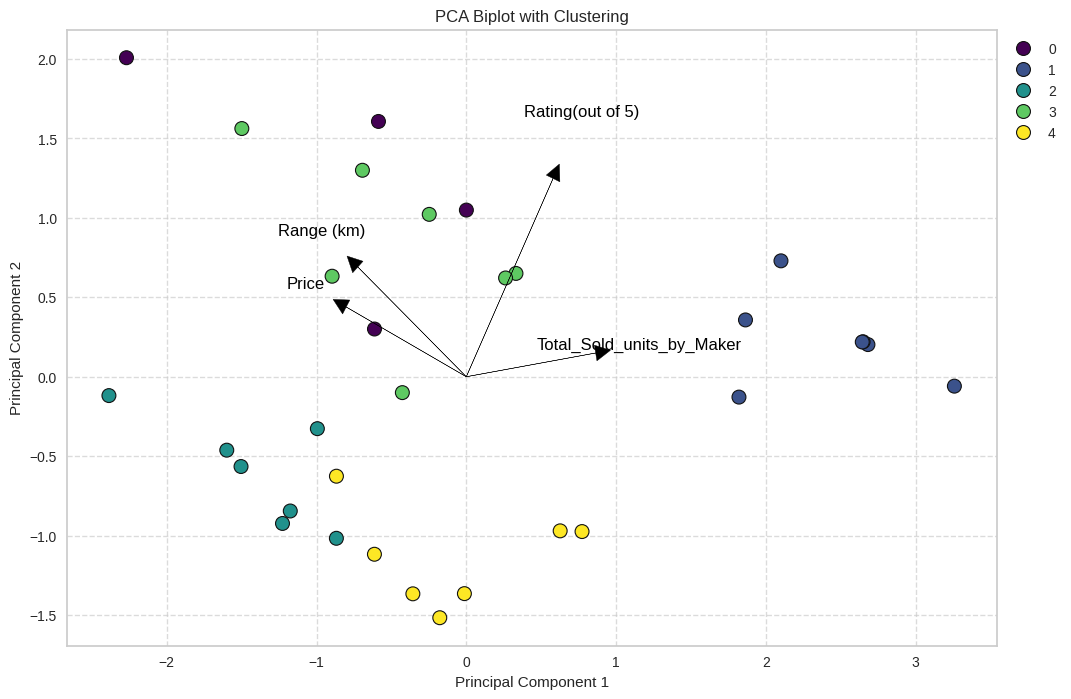

In [224]:
# Plot PCA Biplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', edgecolor='k', s=100)

# Add arrows for feature loadings
features = X.columns
for i, feature in enumerate(features):
    plt.arrow(0, 0, pca.components_[0, i]*1.5, pca.components_[1, i]*1.5,
              head_width=0.1, head_length=0.1, fc='black', ec='black')
    plt.text(pca.components_[0, i] * 2, pca.components_[1, i] * 2, feature,
             color='black', ha='center', va='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot with Clustering')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


>Observations:


* Price: This arrow points leftward and slightly upwards, indicating a negative correlation with PC1 and a small positive correlation with PC2. Vehicles with higher prices are associated with lower PC1 values.
* Range (km): This arrow points leftward and slightly upwards, similar to the Price arrow, indicating a strong negative correlation with PC1 and a slight positive correlation with PC2.
* Rating (out of 5): This arrow points upward and slightly to the right, indicating that higher ratings are positively correlated with both PC1 and PC2.
* Total Sold Units by Maker: The arrow points to the right, showing a strong positive correlation with PC1 and a small positive correlation with PC2.
* "Price" and "Range (km)" are negatively correlated with "Total Sold Units by Maker."

In [225]:
# Add cluster labels to the original DataFrame
df4['Segment'] = clusters
import pandas as pd

# Set pandas display options
pd.set_option('display.float_format', '{:,.2f}'.format)

# Group by cluster and calculate the mean of numeric features
cluster_profiles = df4.groupby('Segment').mean()
print("Cluster Profiles:")
cluster_profiles


Cluster Profiles:


,Rating(out of 5),Range (km),Price,Total_Sold_units_by_Maker
Segment,,,,
0,4.80,683.75,"8,371,250.00",823.75
1,4.93,351.57,"1,421,571.43","19,750.71"
2,4.03,501.57,"14,489,428.57",822.57
3,4.86,468.57,"13,352,571.43",565.86
4,4.14,432.43,"3,603,285.71","1,159.86"


> `Segment 1` emerges as the best target cluster due to the following reasons:

* High Market Demand: The cluster has by far the highest total sold units, indicating a strong preference in the market.
* Affordability: The lower price point makes it accessible to a wider audience.
* High Customer Satisfaction: The highest rating among the clusters suggests that customers are very satisfied with vehicles in this cluster.